В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [69]:
from scripts.process_bank_churn import preprocess_data, preprocess_new_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('data/bank-customer-churn-prediction-dlu/train.csv')
data = preprocess_data(df)

In [13]:
X_train = data['inputs_train']
train_targets = data['targets_train']['Exited']
X_val = data['inputs_val']
val_targets = data['targets_val']['Exited']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [23]:
kNN = KNeighborsClassifier();
kNN.fit(X_train, train_targets)
train_targets_pred = kNN.predict(X_train)
val_targets_pred = kNN.predict(X_val)

In [25]:
score_train = roc_auc_score(train_targets, train_targets_pred)
score_val = roc_auc_score(val_targets, val_targets_pred)
print("Roc auc score train {}".format(score_train))
print("Roc auc score val {}".format(score_val))

Roc auc score train 0.5857252152792775
Roc auc score val 0.5043350024007134


На мою думку модель погана, вона на валідаційних даних вгадує з вірогідність 50%

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [31]:
model = KNeighborsClassifier()
params = {'n_neighbors' : range(1, 10)}
search = GridSearchCV(
    model,
    params,
    cv = 5,
    scoring='roc_auc',
    verbose=3
)

In [32]:
search.fit(X_train, train_targets)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.517 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.502 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.490 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.497 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.503 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.530 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.495 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.503 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.483 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.522 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.529 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10)}, scoring='roc_auc',
             verbose=3)

In [33]:
search.best_params_

{'n_neighbors': 5}

На жаль схоже, що параметр n_neghbors = 5 (як за замовчуванням) - найкращий  

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [39]:
%%time
modelT = DecisionTreeClassifier(random_state=42)
paramsT = {'max_depth':range(1, 20, 2), 'max_leaf_nodes':range(2, 10)}
search_tree = GridSearchCV(
    modelT,
    paramsT,
    cv=3,
    scoring='roc_auc'
)
search_tree.fit(X_train, train_targets)

CPU times: user 3.46 s, sys: 214 ms, total: 3.68 s
Wall time: 3.75 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(1, 20, 2),
                         'max_leaf_nodes': range(2, 10)},
             scoring='roc_auc')

In [42]:
dt_best = search_tree.best_estimator_

In [44]:
print(search_tree.best_params_)

{'max_depth': 5, 'max_leaf_nodes': 9}


In [46]:
train_targets_predT = dt_best.predict(X_train)
val_targets_predT = dt_best.predict(X_val)
train_scoreT = roc_auc_score(train_targets, train_targets_predT)
val_scoreT = roc_auc_score(val_targets, val_targets_predT)
print("Train score {}".format(train_scoreT))
print("Val score {}".format(val_scoreT))

Train score 0.7587714281003726
Val score 0.7377460731188695


Бачу набагато кращі результати для дерева? ніж у КНН

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [58]:
%%time
modelT2 = DecisionTreeClassifier(random_state=42)
paramsT2 = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}
search_tree2 = RandomizedSearchCV(
    modelT2,
    paramsT2,
    cv=3,
    scoring='roc_auc',
    n_iter = 40
)
search_tree2.fit(X_train, train_targets)

CPU times: user 1.04 s, sys: 100 ms, total: 1.14 s
Wall time: 1.19 s


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   scoring='roc_auc')

In [59]:
dt_random_search_best = search_tree2.best_estimator_
rs_target_pred_train = dt_random_search_best.predict(X_train)
rs_target_pred_val = dt_random_search_best.predict(X_val)
rs_score_train = roc_auc_score(train_targets, rs_target_pred_train)
rs_score_val = roc_auc_score(val_targets, rs_target_pred_val)
print("Train score for randomsearch {}".format(rs_score_train))
print("Validation score for randomsearch {}".format(rs_score_val))

Best params 
Train score for randomsearch 0.7894392607936539
Validation score for randomsearch 0.787728925166335


In [60]:
search_tree2.best_params_

{'splitter': 'best',
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 19,
 'max_features': None,
 'max_depth': 14,
 'criterion': 'entropy'}

По часу RandomizedSearchCV відпрацював вдвічі швидше

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [67]:
testdf = pd.read_csv("data/bank-customer-churn-prediction-dlu/test.csv")

In [74]:
print(data.keys())

dict_keys(['inputs_train', 'inputs_val', 'targets_train', 'targets_val', 'scalerObj', 'encoderObj', 'number_cols', 'categorical_cols', 'number_cols_to_scale'])


In [78]:
scalerObj = data['scalerObj']
encoderObj = data['encoderObj']
number_cols = data['number_cols']
number_cols_to_scale = data['number_cols_to_scale']
categorical_cols = data['categorical_cols']

In [79]:
test_data = preprocess_new_data(testdf, scalerObj, encoderObj, number_cols=number_cols, number_cols_to_scale=number_cols_to_scale, categorical_cols=categorical_cols)

In [108]:
test_data

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,15000,15594796.0,0.365155,0.214286,2.0,0.696265,1.0,1.0,1.0,0.789477,0.0,1.0,0.0,0.0,1.0
1,15001,15642821.0,0.286396,0.375000,5.0,0.000000,2.0,1.0,1.0,0.337131,1.0,0.0,0.0,0.0,1.0
2,15002,15716284.0,0.656325,0.446429,8.0,0.000000,2.0,1.0,0.0,0.783859,1.0,0.0,0.0,0.0,1.0
3,15003,15785078.0,0.682578,0.482143,3.0,0.000000,1.0,1.0,1.0,0.834571,0.0,0.0,1.0,0.0,1.0
4,15004,15662955.0,0.384248,0.446429,8.0,0.000000,2.0,1.0,1.0,0.718421,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,0.496420,0.357143,10.0,0.000000,2.0,1.0,1.0,0.248154,0.0,0.0,1.0,0.0,1.0
9996,24996,15739271.0,0.589499,0.375000,9.0,0.000000,2.0,1.0,1.0,0.712578,0.0,0.0,1.0,0.0,1.0
9997,24997,15756743.0,0.818616,0.214286,9.0,0.000000,2.0,1.0,0.0,0.024253,1.0,0.0,0.0,0.0,1.0
9998,24998,15680167.0,0.391408,0.357143,6.0,0.690650,1.0,1.0,0.0,0.632348,1.0,0.0,0.0,0.0,1.0


In [109]:
test_predicted = dt_random_search_best.predict_proba(test_data)

In [110]:
test_predicted[:, 1]

array([0.25432526, 0.0116831 , 0.14645309, ..., 0.0116831 , 0.03872967,
       0.18639053])

In [112]:
result = pd.concat([test_data['id'], pd.Series(test_predicted[:, 1], name='Exited')], axis=1)
result

,id,Exited
0,15000,0.254325
1,15001,0.011683
2,15002,0.146453
3,15003,0.767635
4,15004,0.078273
...,...,...
9995,24995,0.011683
9996,24996,0.011683
9997,24997,0.011683
9998,24998,0.038730


In [113]:
result.to_csv("data/bank-customer-churn-prediction-dlu/submission_tree_randomcv.csv", index=False)

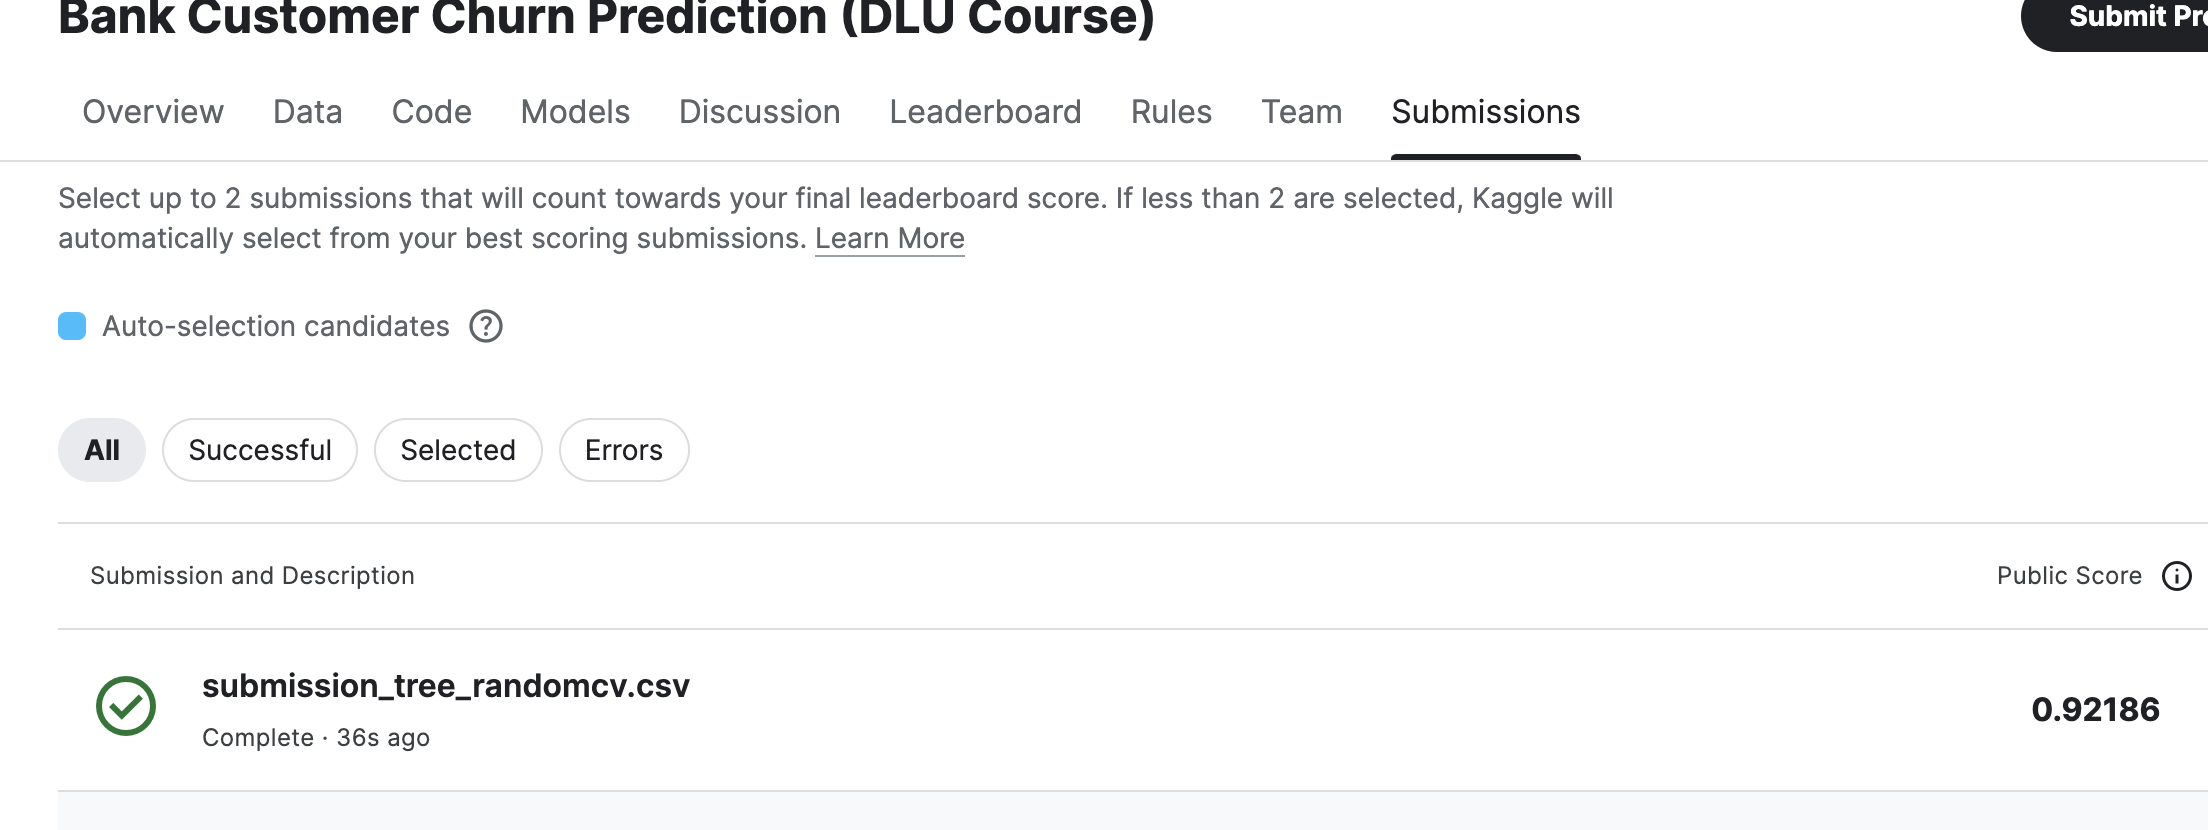

Все одно результат гірший)